In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def obj_func(m):
    svd = np.linalg.svd(m, compute_uv=False)

    return np.sum(svd[1:]) 

In [3]:

def get_min_knowns(n,prev_knowns=1):
    
    rank = 1

    U = np.random.randn(n, rank)
    V = np.random.randn(n, rank)
    original = np.dot(U, V.T)

    for knowns in range(np.max([prev_knowns - 20, 1]), n*n):
        max_steps = 100000
        threshold = 1 # distance between solution and answer when they are considered the same

        unknowns = n*n - knowns

        #print('>',n*n, unknowns)
        
        mask = np.array([0] * unknowns + [1] * (n*n - unknowns))
        np.random.shuffle(mask)
        mask = np.reshape(mask, [n,n])
        mask = np.ma.make_mask(mask)


        
        # First try Newton's method:

        def comp_grad(m, boolMask, obj_func):
            """ Computes gradient that maximizes the objective function """
            epsilon = 1e-3

            # Yes, grad is a vector now
            grad = []

            for i in range(n):
                for j in range(n):
                    if boolMask[i,j] and np.random.random() > 1 - portion:
                        diff = np.zeros([n,n])
                        diff[i,j] = epsilon
                        grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))

            return grad

        def comp_hessian(m, boolMask, of):
            """ Computes hessian (only diagonal) """
            epsilon = 1e-3

            hessian = []

            for i in range(n):
                for j in range(n):
                    if boolMask[i,j]:
                        row = []

                        diff = np.zeros([n,n])
                        diff[i,j] = epsilon
                        hessian.append((of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2)

            return hessian


        starting_point = np.copy(original)

        boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
        starting_point[boolMask] = 0

        prev_norm = np.linalg.norm(starting_point,'nuc')

        norms = []
        distances = []
        sing_vals = []

        current_point = starting_point

        #pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
        #          interpolation='nearest', vmin=0, vmax=1)
        #pl.colorbar()


        initial_s = 4
        s = 4
        portion = 1.1
        for i in range(max_steps):
            cur_norm = np.linalg.norm(current_point,'nuc')
            norms.append(cur_norm)
            sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
            distances.append(np.linalg.norm(current_point-original,'fro'))
            diff = cur_norm - prev_norm

            # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
            #portion = 1 - np.exp(-1/(20*s))
            #if i % 1000 == 0:
            #print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
            prev_norm = cur_norm
            
            if np.linalg.norm(current_point-original,'fro') < threshold:
                return knowns
            
            if diff >= 0 and i > 1:
                break

            ### slowest part of the code ###
            descent = np.linalg.lstsq(np.diag(comp_hessian(current_point,boolMask,obj_func)),
               comp_grad(current_point,boolMask,obj_func), rcond=None)[0]

            descent_matrix = np.zeros([n,n])
            count = 0
            for i in range(n):
                for j in range(n):
                    if boolMask[i,j]:
                        descent_matrix[i,j] = descent[count]
                        count = count + 1

            reg = 0.39
            next_point = current_point - reg*descent_matrix

            current_point = next_point

        # Next try gradient descent:
        
        def comp_grad(m,boolMask):
            """ Computes gradient that maximizes the objective function """
            epsilon = 1e-3

            grad = np.zeros([n,n])

            for i in range(n):
                for j in range(n):
                    if boolMask[i,j]:
                        diff = np.zeros([n,n])
                        diff[i,j] = epsilon
                        grad[i,j] = (obj_func(m + diff) - obj_func(m - diff))/(2*epsilon)

            return grad
        
        def line_search(point, grad, obj_func, s = 4, threshold = 1e-10):
            """ Finds a maximum step size that maximizes the descent (since computing gradient is hard) """

            choice = point - grad * s
            while obj_func(choice) > obj_func(point):
                s = s / 2
                choice = point - grad * s

            initial_s = s

            while True:
                left = choice + grad * s/2
                right = point - grad * s/2

                s = s / 2
                if obj_func(left) < obj_func(right):
                    choice = left
                else:
                    choice = right

                if np.abs(obj_func(left) - obj_func(right)) < threshold:
                    break

            return (choice, initial_s, s)

        starting_point = np.copy(original)

        boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
        starting_point[boolMask] = 0

        prev_norm = np.linalg.norm(starting_point,'nuc')

        norms = []
        distances = []
        sing_vals = []

        current_point = starting_point

        initial_s = 4
        s = 4
        portion = 1.1
        for i in range(threshold):
            cur_norm = np.linalg.norm(current_point,'nuc')
            norms.append(cur_norm)
            sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
            distances.append(np.linalg.norm(current_point-original,'fro'))
            diff = cur_norm - prev_norm

            #print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'))
            prev_norm = cur_norm
            
            if np.linalg.norm(current_point-original,'fro') < threshold:
                return knowns
            
            if diff >= 0 and i > 1:
                break

            ### slowest part of the code ###
            grad = comp_grad(current_point,boolMask)
            current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

    return False

In [4]:
get_min_knowns(4)

14

In [5]:
n_vals = []
min_knowns_vals = []

prev = 1
for n in range(4,10000):
    min_knowns = get_min_knowns(n, prev)
    if min_knowns:
        prev = min_knowns
        n_vals.append(n)
        min_knowns_vals.append(min_knowns)
        print(n, min_knowns)

4 7
5 23
6 27
8 34
9 57
10 64
11 70
12 129
13 110
14 129
15 144
16 142
17 186
18 202
19 203
20 257
21 243
22 280
23 309
24 329
25 372
26 355
27 340
28 400
29 478
30 482
31 478
32 518
33 506
34 506
35 575


KeyboardInterrupt: 

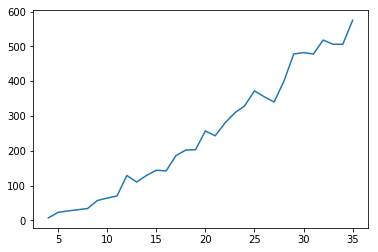

In [6]:
plt.plot(n_vals, min_knowns_vals)

In [7]:
np.save('convergence-reuse_results-rank1-ignore_only_one_singular_value_n_vals', n_vals)
np.save('convergence-reuse_results-rank1-ignore_only_one_singular_value_min_known_vals', min_knowns_vals)

Displaying plot 1


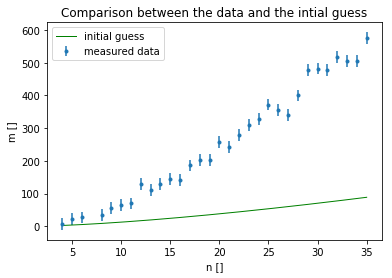


Goodness of fit - chi square measure:
Chi2 = 37.775171596727226, Chi2/dof = 1.3025921240250768

Fit parameters:
C = 1.719e+00 +/- 2.596e-01
b = 1.279e+00 +/- 4.521e-02
Displaying plot 2


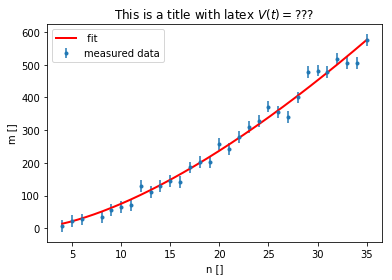


Residual information:
67.7% of data points agree with fit

Displaying plot 3


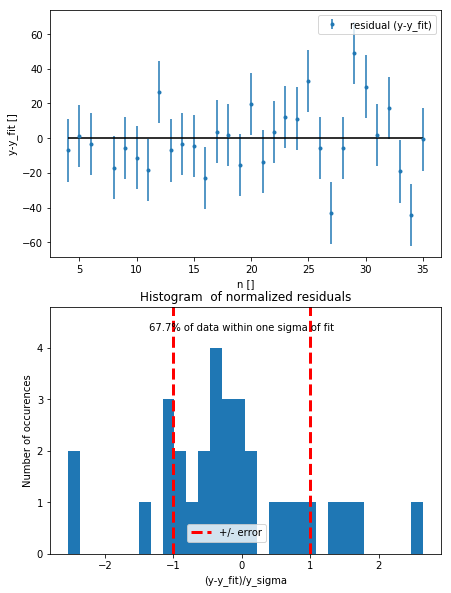

In [14]:
from scipy.optimize import curve_fit

x_name = 'n'
x_units = ''
y_name = 'm'
y_units = '' 
guesses = (0.35,1.2)

def fit_function(x, a, b):
    return a * x**b * np.log(x)

x = n_vals#np.arange(np.size(dims)) 
y = min_knowns_vals#dims

#x = x[1:]
#y = y[1:]

y_sigma = np.ones(np.size(x))
y_sigma=y_sigma*18

x_fitfunc=np.linspace(min(x),max(x),500)
    
#compares the guessed curve to the data for visual reference
y_guess = fit_function(x_fitfunc,*guesses)
plt.errorbar(x,y,yerr=y_sigma,marker='.',linestyle='',label="measured data")
plt.plot(x_fitfunc,y_guess,marker="",linestyle="-",linewidth=1,color="g",
         label="initial guess")
plt.xlabel('{} [{}]'.format(x_name,x_units))
plt.ylabel('{} [{}]'.format(y_name,y_units))
plt.title('Comparison between the data and the intial guess')
plt.legend(loc='best',numpoints=1)
print ('Displaying plot 1')
plt.show()


    
    
# fit the data to fit_function. fit_params is the resultant parameters, fit_cov
# is the covariance matrix between all the parameters. maxfev=10**5 means the
# fitting procedure is iterated at maximum 10^5 times before giving up.
fit_params,fit_cov = curve_fit(fit_function,x,y,sigma=y_sigma,p0=guesses,
                               maxfev=10**5)
                               
###############################################################################
# prints the chi2 
###############################################################################

# function that  calculates the chi square value of a fit
def chi_square (fit_parameters, x, y, sigma):
#
    return np.sum((y-fit_function(x, *fit_parameters))**2/sigma**2)
    
# calculate and print chi square as well as the per degree-of-freedom value
chi2 = chi_square(fit_params,x,y,y_sigma)
dof = len(x) - len(fit_params)
print ("\nGoodness of fit - chi square measure:")
print ("Chi2 = {}, Chi2/dof = {}\n".format(chi2, chi2/dof))

###############################################################################
# prints the fit parameters (with uncertainty)
###############################################################################

# the covariance matrix is rescaled to cancel the inverse scaling that is 
# performed for numerical reasons during execution of curve_fit -- do not 
# change this line!
fit_cov = fit_cov*dof/chi2
# calculate the standard deviation as uncertainty of the fit parameters
fit_params_error = np.sqrt(np.diag(fit_cov))

# read out parameter results
param_names = ['C','b']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print ('{} = {:.3e} +/- {:.3e}'.format(param_names[i],
                                          fit_params[i],
                                          fit_params_error[i]))


# prints out the covariance between all variables. Uncomment this code to see
# the results of this more sophisticated statistical measure.
#print "\nCovariance between fit parameters:"
#for i,fit_covariance in enumerate(fit_cov):
#    for j in xrange(i+1,len(fit_covariance)) :
#        print "{} and {} : {:.3e}".format(param_names[i],
#                                          param_names[j],
#                                          fit_cov[i,j])
                                                                        
###############################################################################
# plots the data and the fit curve
###############################################################################
    
# y_fitfunc is the curve using the parameters calculated from the fit
#x_fit = np.linspace(min(f),max(f),len(f))
y_fitfunc = fit_function(x_fitfunc,*fit_params)
# plots y, and y_fit on the same plot.
# marker='.' : data points are not indicated by markers
# linestyle= '-' : a continuous line is drawn
# linewidth=2 : the line thickness is set to 2
# color='r' : the color of the line is set to red
# label=string : the string is shown in the legend
plt.errorbar(x,y,yerr=y_sigma,marker='.',linestyle='',label="measured data")
plt.plot(x_fitfunc,y_fitfunc,marker="",linestyle="-",linewidth=2,color="r",
         label=" fit")
# add axis labels and title
plt.xlabel('{} [{}]'.format(x_name,x_units))
plt.ylabel('{} [{}]'.format(y_name,y_units))
plt.title(r'This is a title with latex $V(t)=???$')
# set the x and y boundaries of your plot
#plt.xlim(lower_x,upper_x)
#plt.ylim(lower_y,upper_y)
# show a legend. loc='best' places legend where least amount of data is 
# obstructed. 
plt.legend(loc='best',numpoints=1)
print ('Displaying plot 2')
# plt.show() may or may not need to be commented out depending on your python
# editor (spyder) settings.
plt.show()


###############################################################################
# plots residual and histogram of residual. Don't touch this par tof the code
###############################################################################

# residual is the difference between the data and theory
y_fit=fit_function(x,*fit_params)
residual = y-y_fit
#calculate normalized residuals
normresidual=residual/y_sigma
# creates a histogram of the normalized residuals
hist,bins = np.histogram(normresidual,bins=30)

# this complicated code produces a figure with a plot of the residuals as well
# as a histogram of the residuals. You do not need to understand this code.
fig = plt.figure(figsize=(7,10))
ax1 = fig.add_subplot(211)
ax1.errorbar(x,residual,yerr=y_sigma,marker='.',linestyle='',
             label="residual (y-y_fit)")
ax1.hlines(0,np.min(x),np.max(x),lw=2,alpha=0.8)
ax1.set_xlabel('{} [{}]'.format(x_name,x_units))
ax1.set_ylabel('y-y_fit [{}]'.format(y_units))
ax1.legend(loc='best',numpoints=1)
ax2 = fig.add_subplot(212)
ax2.bar(bins[:-1],hist,width=bins[1]-bins[0])

ax2.set_ylim(0,1.2*np.max(hist))
ax2.set_xlabel('(y-y_fit)/y_sigma')
ax2.set_ylabel('Number of occurences')
plt.title('Histogram  of normalized residuals')
#if y_sigma != None:
# within_err is the percentage of data points whose error bars overlap with 
# the fit. If chi2/dof = 1, within_error ~ 66% (one standard deviation)
within_err=100.*np.sum((residual<=y_sigma)&(residual>=-y_sigma))/len(residual)
print ("\nResidual information:")
print ('{:.1f}% of data points agree with fit'.format(within_err))
ax2.vlines(-1.0,0,np.max(hist)*1.3,lw=3,color='r',linestyles='--')
ax2.vlines(+1.0,0,np.max(hist)*1.3,lw=3,color='r',linestyles='--',label='+/- error')
ax2.text(0.0,np.max(hist)*1.1,'{:.1f}% of data within one sigma of fit'.format(within_err),
         horizontalalignment='center',verticalalignment='center')
ax2.legend(loc=(0.35,0.05))

print ('\nDisplaying plot 3')
plt.show()